---

# Notebook : Évaluation avancée des modèles et validation croisée imbriquée pour stabilité

**Objectifs :**
1. **Partie 1** : Validation croisée imbriquée avec stacking avancé pour une évaluation robuste et minimisation du surajustement.
2. **Partie 2** : Évaluation par validation croisée des modèles validés individuellement (`Gradient Boosting` et `Random Forest`).

---

### Partie 1 : Validation croisée imbriquée avec stacking avancé

#### Étape 1 : Importer les bibliothèques nécessaires et désactiver les avertissements

In [1]:
import pandas as pd
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
import numpy as np
import warnings

# Désactiver les avertissements liés à joblib

In [2]:
warnings.filterwarnings("ignore", category=UserWarning, module="joblib")

#### Étape 2 : Charger les données et préparer les variables

In [3]:
file_path = 'note-books/phase_2_training/04_correlation_analysis/data_final_features.csv'
df = pd.read_csv(file_path)
df['nutriscore_grade_encoded'] = df['nutriscore_grade'].map({'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4})

X = df[['fat_100g', 'saturated-fat_100g', 'energy-kcal_100g', 'sugars_100g', 'salt_100g', 'proteins_100g']]
y = df['nutriscore_grade_encoded']

#### Étape 3 : Configurer les modèles de base et le meta-modèle

In [4]:
base_models = [
    ('random_forest', RandomForestRegressor(n_estimators=200, max_depth=20, random_state=42)),
    ('gradient_boosting', GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42))
]
meta_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
stacking_regressor = StackingRegressor(estimators=base_models, final_estimator=meta_model, n_jobs=-1)


#### Étape 4 : Configurer la validation croisée imbriquée avec RandomizedSearchCV

In [5]:
outer_cv = KFold(n_splits=3, shuffle=True, random_state=42)
inner_cv = KFold(n_splits=3, shuffle=True, random_state=42)
param_grid = {
    'final_estimator__n_estimators': [100, 200],
    'final_estimator__learning_rate': [0.01, 0.1],
    'final_estimator__max_depth': [3, 5]
}
random_search = RandomizedSearchCV(
    estimator=stacking_regressor,
    param_distributions=param_grid,
    scoring=make_scorer(mean_squared_error, greater_is_better=False),
    cv=inner_cv,
    n_iter=5,
    n_jobs=1
)

#### Étape 5 : Exécuter la validation croisée imbriquée

In [6]:
outer_results = []
for train_ix, test_ix in outer_cv.split(X):
    X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
    y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]
    random_search.fit(X_train, y_train)
    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    outer_results.append((mse, r2))
    print(f"Score sur le pli de test: MSE = {mse}, R² = {r2}")

mse_scores, r2_scores = zip(*outer_results)
print(f"\nPerformance moyenne avec validation croisée imbriquée :")
print(f"MSE moyen : {np.mean(mse_scores)}, Écart-type du MSE : {np.std(mse_scores)}")
print(f"R² moyen : {np.mean(r2_scores)}, Écart-type du R² : {np.std(r2_scores)}")

Score sur le pli de test: MSE = 0.3602871777390144, R² = 0.8001612424850464
Score sur le pli de test: MSE = 0.37091493964888983, R² = 0.7935717105865479
Score sur le pli de test: MSE = 0.36089279420419085, R² = 0.8000110983848572

Performance moyenne avec validation croisée imbriquée :
MSE moyen : 0.36403163719736503, Écart-type du MSE : 0.004873505398587938
R² moyen : 0.7979146838188171, Écart-type du R² : 0.0030715574968693065


---

### Partie 2 : Création de pipeline et évaluation par validation croisée des modèles validés

#### Étape 1 : Importer les bibliothèques nécessaires et charger les modèles sauvegardés

In [7]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import joblib
import matplotlib.pyplot as plt

#### Étape 2 : Charger les données et préparer un échantillon de 10%

In [8]:
X_sample, _, y_sample, _ = train_test_split(X, y, test_size=0.9, random_state=42)

#### Étape 3 : Charger les modèles sauvegardés et configurer les pipelines

In [9]:
model_paths = {
    'Gradient Boosting': 'note-books/phase_2_training/06_model_selection_comparison/Gradient_Boosting_optimized.joblib',
    'Random Forest': 'note-books/phase_2_training/06_model_selection_comparison/Random_Forest_optimized.joblib'
}
pipelines = {}
for model_name, model_path in model_paths.items():
    model = joblib.load(model_path)
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])
    pipelines[model_name] = pipeline

#### Étape 4 : Évaluation des modèles avec validation croisée

In [10]:
scoring = {
    'MSE': make_scorer(mean_squared_error, greater_is_better=False),
    'R²': make_scorer(r2_score)
}
results = {'Model': [], 'MSE Mean': [], 'MSE Std Dev': [], 'R² Mean': [], 'R² Std Dev': []}

for model_name, pipeline in pipelines.items():
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    mse_scores = cross_val_score(pipeline, X_sample, y_sample, cv=kfold, scoring=scoring['MSE'])
    r2_scores = cross_val_score(pipeline, X_sample, y_sample, cv=kfold, scoring=scoring['R²'])
    results['Model'].append(model_name)
    results['MSE Mean'].append(-np.mean(mse_scores))
    results['MSE Std Dev'].append(np.std(mse_scores))
    results['R² Mean'].append(np.mean(r2_scores))
    results['R² Std Dev'].append(np.std(r2_scores))
    print(f"{model_name} terminé. MSE moyen : {-np.mean(mse_scores)}, Écart-type MSE : {np.std(mse_scores)}, "
          f"R² moyen : {np.mean(r2_scores)}, Écart-type R² : {np.std(r2_scores)}")

Gradient Boosting terminé. MSE moyen : 0.5025002394666422, Écart-type MSE : 0.017039842086640906, R² moyen : 0.720147056821588, Écart-type R² : 0.006639634197023367
Random Forest terminé. MSE moyen : 0.4470307692753178, Écart-type MSE : 0.012634819134212355, R² moyen : 0.7504938420698044, Écart-type R² : 0.0046089052174416055


#### Étape 5 : Afficher les résultats sous forme de graphiques

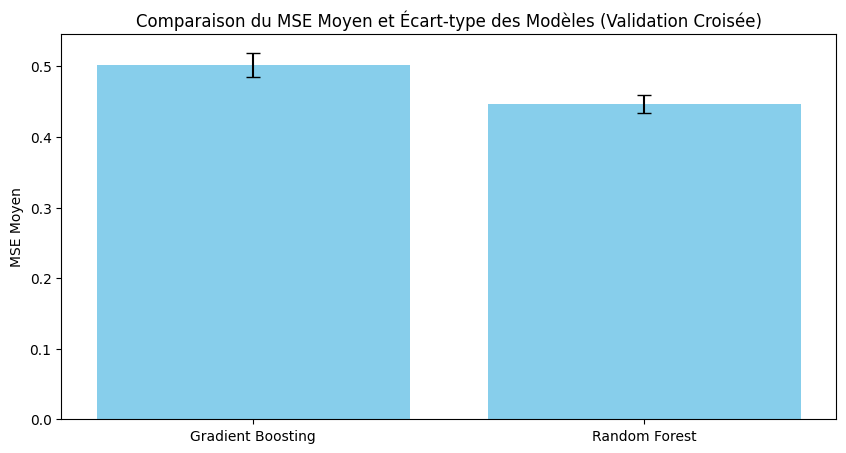

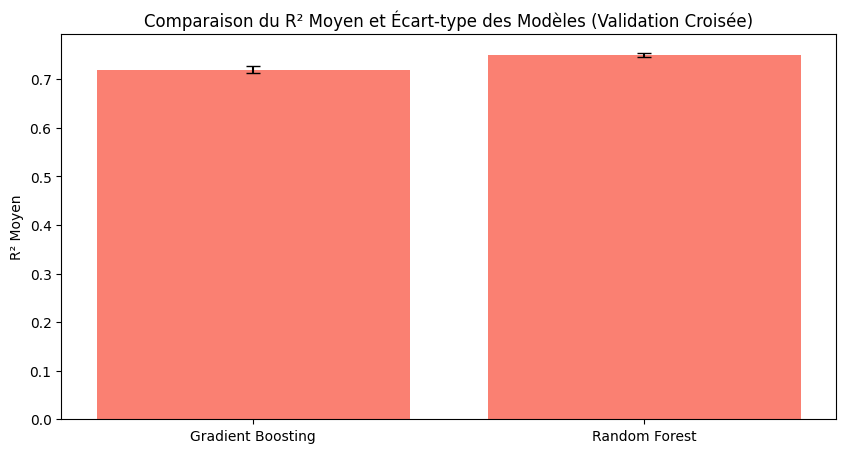

In [11]:
results_df = pd.DataFrame(results)
plt.figure(figsize=(10, 5))
plt.bar(results_df['Model'], results_df['MSE Mean'], yerr=results_df['MSE Std Dev'], capsize=5, color='skyblue')
plt.ylabel('MSE Moyen')
plt.title("Comparaison du MSE Moyen et Écart-type des Modèles (Validation Croisée)")
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(results_df['Model'], results_df['R² Mean'], yerr=results_df['R² Std Dev'], capsize=5, color='salmon')
plt.ylabel('R² Moyen')
plt.title("Comparaison du R² Moyen et Écart-type des Modèles (Validation Croisée)")
plt.show()


---

### Explication des étapes

- **Validation croisée imbriquée avec Stacking avancé** : Permet une évaluation robuste pour le modèle de stacking, en minimisant le surajustement.
- **Validation croisée des modèles validés** : Utilisation d'une validation croisée standard pour évaluer individuellement `Gradient Boosting`